# Assessing Fire Risk in NYC

## Import Libraries

In [1]:
# Data analysis and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

# Interactive maps
import folium
from folium.plugins import HeatMap

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

## Load and describe data
Note: Data was filtered on the NYC OpenData site to only include incident classification groups that were fire-related (Structural and NonStructural Fires) prior to export.

In [2]:
# Load the data into Python

# Fire Incident Dispatch
alarms_df = pd.read_csv('../static/data/raw/In-Service_Alarm_Box_Locations.csv')
dispatch_df = pd.read_csv('../static/data/raw/Fire_Incident_Dispatch_Data.csv')

# Additional factors
factors_df = pd.read_csv('../static/data/processed/factors.csv')

## ELT

In [3]:
alarms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13008 entries, 0 to 13007
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BOROBOX           13008 non-null  object 
 1   BOX_TYPE          13008 non-null  object 
 2   LOCATION          13008 non-null  object 
 3   ZIP               12981 non-null  float64
 4   BOROUGH           13004 non-null  object 
 5   COMMUNITYDISTICT  12866 non-null  object 
 6   CITYCOUNCIL       13004 non-null  float64
 7   LATITUDE          13008 non-null  float64
 8   LONGITUDE         13008 non-null  float64
 9   Location Point    13008 non-null  object 
dtypes: float64(4), object(6)
memory usage: 1016.4+ KB


In [4]:
alarms_df = alarms_df[[
    'BOROUGH',
    'BOROBOX'
]]
alarms_df = alarms_df.rename(columns={
    'BOROBOX': 'ALARM_ID'
})
alarms_df['BOROUGH'] = alarms_df['BOROUGH'].str.upper()
alarms_df['ALARM_ID'] = alarms_df['ALARM_ID'].str[1:]
alarms_df.head()

,BOROUGH,ALARM_ID
0,BROOKLYN,2653
1,QUEENS,7917
2,BROOKLYN,0801
3,BROOKLYN,1046
4,BROOKLYN,0109


In [5]:
dispatch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134205 entries, 0 to 134204
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   STARFIRE_INCIDENT_ID            134205 non-null  int64  
 1   INCIDENT_DATETIME               134205 non-null  object 
 2   ALARM_BOX_BOROUGH               134205 non-null  object 
 3   ALARM_BOX_NUMBER                134205 non-null  int64  
 4   ALARM_BOX_LOCATION              134195 non-null  object 
 5   INCIDENT_BOROUGH                134205 non-null  object 
 6   ZIPCODE                         128109 non-null  float64
 7   POLICEPRECINCT                  128114 non-null  float64
 8   CITYCOUNCILDISTRICT             128110 non-null  float64
 9   COMMUNITYDISTRICT               128112 non-null  float64
 10  COMMUNITYSCHOOLDISTRICT         128101 non-null  float64
 11  CONGRESSIONALDISTRICT           128110 non-null  float64
 12  ALARM_SOURCE_DES

In [6]:
dispatch_df.rename(columns={
    'ALARM_BOX_LOCATION': 'LOCATION',
    'INCIDENT_DATETIME':'DATE',
    'ALARM_BOX_BOROUGH': 'BOROUGH',
    'INCIDENT_CLASSIFICATION': 'TYPE',
    'ALARM_BOX_NUMBER':'ALARM_ID'
}, inplace=True)
dispatch_df = dispatch_df[[
    'BOROUGH',
    'ALARM_ID',
    'LOCATION',
    'DATE',
    'TYPE'
]]
dispatch_df['ALARM_ID'] = dispatch_df['ALARM_ID'].apply(str)
dispatch_df.head()

,BOROUGH,ALARM_ID,LOCATION,DATE,TYPE
0,QUEENS,1151,BAY 28 ST & SUNNYSIDE ST,01/01/2018 12:02:05 AM,Private Dwelling Fire
1,QUEENS,9707,75 AVE & 178 ST,01/01/2018 12:02:54 AM,Private Dwelling Fire
2,BROOKLYN,3776,CHURCH AVE & STORY ST,01/01/2018 12:03:53 AM,Demolition Debris or Rubbish Fire
3,QUEENS,5210,LINDEN BLVD & 121 ST,01/01/2018 12:13:46 AM,Demolition Debris or Rubbish Fire
4,BRONX,3173,CROTONA AVE & 182 ST,01/01/2018 12:14:20 AM,Multiple Dwelling 'A' - Food on the stove fire


In [7]:
fires_df = alarms_df.merge(dispatch_df, how='outer', on=['BOROUGH','ALARM_ID'])
fires_df.head()

,BOROUGH,ALARM_ID,LOCATION,DATE,TYPE
0,BROOKLYN,2653,3 AVE & 65 ST,02/06/2018 03:40:32 AM,Automobile Fire
1,BROOKLYN,2653,3 AVE & 65 ST,07/13/2018 01:55:49 PM,Multiple Dwelling 'A' - Other fire
2,BROOKLYN,2653,3 AVE & 65 ST,08/06/2018 06:32:28 AM,Demolition Debris or Rubbish Fire
3,BROOKLYN,2653,3 AVE & 65 ST,09/13/2018 06:27:32 PM,Multiple Dwelling 'A' - Other fire
4,BROOKLYN,2653,3 AVE & 65 ST,09/16/2018 09:51:51 AM,Multiple Dwelling 'A' - Food on the stove fire


In [8]:
# Verify nulls exist
nulls = pd.isnull(fires_df['DATE'])
fires_df[nulls]

,BOROUGH,ALARM_ID,LOCATION,DATE,TYPE
33,BROOKLYN,0801,NaN,NaN,NaN
34,BROOKLYN,0801,NaN,NaN,NaN
35,BROOKLYN,0801,NaN,NaN,NaN
36,BROOKLYN,0801,NaN,NaN,NaN
55,BROOKLYN,0109,NaN,NaN,NaN
...,...,...,...,...,...
81508,MANHATTAN,0032,NaN,NaN,NaN
81533,QUEENS,0021,NaN,NaN,NaN
81541,BROOKLYN,0142,NaN,NaN,NaN
81568,STATEN ISLAND,0882,NaN,NaN,NaN


In [9]:
fires_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149265 entries, 0 to 149264
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   BOROUGH   149261 non-null  object
 1   ALARM_ID  149265 non-null  object
 2   LOCATION  144660 non-null  object
 3   DATE      144670 non-null  object
 4   TYPE      144670 non-null  object
dtypes: object(5)
memory usage: 6.8+ MB


In [10]:
fires_df['DATE'] = pd.to_datetime(fires_df['DATE'],infer_datetime_format=True)
fires_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149265 entries, 0 to 149264
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   BOROUGH   149261 non-null  object        
 1   ALARM_ID  149265 non-null  object        
 2   LOCATION  144660 non-null  object        
 3   DATE      144670 non-null  datetime64[ns]
 4   TYPE      144670 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.8+ MB


In [11]:
factors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DATE                  241 non-null    object 
 1   BOROUGH               205 non-null    object 
 2   NYPD_COMPLAINT_COUNT  216 non-null    float64
 3   CODE_VIOLATION_COUNT  205 non-null    float64
 4   VACATE_ORDER_COUNT    195 non-null    float64
dtypes: float64(3), object(2)
memory usage: 9.5+ KB


In [12]:
factors_df.head()

,DATE,BOROUGH,NYPD_COMPLAINT_COUNT,CODE_VIOLATION_COUNT,VACATE_ORDER_COUNT
0,2018-01-01,BRONX,8337.0,13430.0,25.0
1,2018-01-01,BROOKLYN,11193.0,17188.0,30.0
2,2018-01-01,MANHATTAN,9614.0,8279.0,13.0
3,2018-01-01,QUEENS,7450.0,4191.0,14.0
4,2018-01-01,STATEN ISLAND,1677.0,545.0,7.0


In [13]:
factors_df['DATE'] = pd.to_datetime(factors_df['DATE'],infer_datetime_format=True)
factors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  241 non-null    datetime64[ns]
 1   BOROUGH               205 non-null    object        
 2   NYPD_COMPLAINT_COUNT  216 non-null    float64       
 3   CODE_VIOLATION_COUNT  205 non-null    float64       
 4   VACATE_ORDER_COUNT    195 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 9.5+ KB


## Data Wrangling

In [14]:
# Copy into new dataframes for backup purposes
fires = fires_df
factors = factors_df

In [15]:
nulls = pd.isnull(fires['DATE'])
nulls = fires[nulls]
nulls.head()

,BOROUGH,ALARM_ID,LOCATION,DATE,TYPE
33,BROOKLYN,0801,NaN,NaT,NaN
34,BROOKLYN,0801,NaN,NaT,NaN
35,BROOKLYN,0801,NaN,NaT,NaN
36,BROOKLYN,0801,NaN,NaT,NaN
55,BROOKLYN,0109,NaN,NaT,NaN


In [16]:
nulls = nulls.fillna(0)
nulls

,BOROUGH,ALARM_ID,LOCATION,DATE,TYPE
33,BROOKLYN,0801,0,0,0
34,BROOKLYN,0801,0,0,0
35,BROOKLYN,0801,0,0,0
36,BROOKLYN,0801,0,0,0
55,BROOKLYN,0109,0,0,0
...,...,...,...,...,...
81508,MANHATTAN,0032,0,0,0
81533,QUEENS,0021,0,0,0
81541,BROOKLYN,0142,0,0,0
81568,STATEN ISLAND,0882,0,0,0


In [17]:
nulls['FIRE'] = np.where(nulls['TYPE'] == 0, 0, 1)
nulls

,BOROUGH,ALARM_ID,LOCATION,DATE,TYPE,FIRE
33,BROOKLYN,0801,0,0,0,0
34,BROOKLYN,0801,0,0,0,0
35,BROOKLYN,0801,0,0,0,0
36,BROOKLYN,0801,0,0,0,0
55,BROOKLYN,0109,0,0,0,0
...,...,...,...,...,...,...
81508,MANHATTAN,0032,0,0,0,0
81533,QUEENS,0021,0,0,0,0
81541,BROOKLYN,0142,0,0,0,0
81568,STATEN ISLAND,0882,0,0,0,0


In [18]:
fires['FIRE'] = np.where(fires['TYPE'] == 0, 0, 1)
fires.head()

,BOROUGH,ALARM_ID,LOCATION,DATE,TYPE,FIRE
0,BROOKLYN,2653,3 AVE & 65 ST,2018-02-06 03:40:32,Automobile Fire,1
1,BROOKLYN,2653,3 AVE & 65 ST,2018-07-13 13:55:49,Multiple Dwelling 'A' - Other fire,1
2,BROOKLYN,2653,3 AVE & 65 ST,2018-08-06 06:32:28,Demolition Debris or Rubbish Fire,1
3,BROOKLYN,2653,3 AVE & 65 ST,2018-09-13 18:27:32,Multiple Dwelling 'A' - Other fire,1
4,BROOKLYN,2653,3 AVE & 65 ST,2018-09-16 09:51:51,Multiple Dwelling 'A' - Food on the stove fire,1


In [19]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149265 entries, 0 to 149264
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   BOROUGH   149261 non-null  object        
 1   ALARM_ID  149265 non-null  object        
 2   LOCATION  144660 non-null  object        
 3   DATE      144670 non-null  datetime64[ns]
 4   TYPE      144670 non-null  object        
 5   FIRE      149265 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 8.0+ MB


In [20]:
fires['DATE'] = fires['DATE'].dt.to_period('m')
fires.head()

,BOROUGH,ALARM_ID,LOCATION,DATE,TYPE,FIRE
0,BROOKLYN,2653,3 AVE & 65 ST,2018-02,Automobile Fire,1
1,BROOKLYN,2653,3 AVE & 65 ST,2018-07,Multiple Dwelling 'A' - Other fire,1
2,BROOKLYN,2653,3 AVE & 65 ST,2018-08,Demolition Debris or Rubbish Fire,1
3,BROOKLYN,2653,3 AVE & 65 ST,2018-09,Multiple Dwelling 'A' - Other fire,1
4,BROOKLYN,2653,3 AVE & 65 ST,2018-09,Multiple Dwelling 'A' - Food on the stove fire,1


In [21]:
fires['YEAR'] = fires['DATE'].dt.year
year = fires['YEAR']
fires.drop(labels=['YEAR'], axis=1, inplace=True)
fires.insert(1, 'YEAR', year)
fires.head()

,BOROUGH,YEAR,ALARM_ID,LOCATION,DATE,TYPE,FIRE
0,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-02,Automobile Fire,1
1,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-07,Multiple Dwelling 'A' - Other fire,1
2,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-08,Demolition Debris or Rubbish Fire,1
3,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-09,Multiple Dwelling 'A' - Other fire,1
4,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-09,Multiple Dwelling 'A' - Food on the stove fire,1


In [22]:
# Drop rows that contain null values
fires_notna = fires[fires['DATE'].notna()]

In [23]:
fires_notna

,BOROUGH,YEAR,ALARM_ID,LOCATION,DATE,TYPE,FIRE
0,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-02,Automobile Fire,1
1,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-07,Multiple Dwelling 'A' - Other fire,1
2,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-08,Demolition Debris or Rubbish Fire,1
3,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-09,Multiple Dwelling 'A' - Other fire,1
4,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-09,Multiple Dwelling 'A' - Food on the stove fire,1
...,...,...,...,...,...,...,...
149260,MANHATTAN,2021,4444,DECON UNITS OUT OF SERVICE,2021-05,Brush Fire,1
149261,QUEENS,2021,4054,CORPORAL KENNEDY ST & 28 RD,2021-05,Private Dwelling Fire,1
149262,RICHMOND / STATEN ISLAND,2021,243,BAY ST & UNION PL,2021-05,Demolition Debris or Rubbish Fire,1
149263,RICHMOND / STATEN ISLAND,2021,642,HOPE AV-200' E OF BEETHOVEN ST,2021-05,Multiple Dwelling 'B' Fire,1


In [24]:
fires_notna.loc[fires_notna['BOROUGH']=='RICHMOND / STATEN ISLAND', 'BOROUGH'] = 'STATEN ISLAND'

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [25]:
fires_notna

,BOROUGH,YEAR,ALARM_ID,LOCATION,DATE,TYPE,FIRE
0,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-02,Automobile Fire,1
1,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-07,Multiple Dwelling 'A' - Other fire,1
2,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-08,Demolition Debris or Rubbish Fire,1
3,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-09,Multiple Dwelling 'A' - Other fire,1
4,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-09,Multiple Dwelling 'A' - Food on the stove fire,1
...,...,...,...,...,...,...,...
149260,MANHATTAN,2021,4444,DECON UNITS OUT OF SERVICE,2021-05,Brush Fire,1
149261,QUEENS,2021,4054,CORPORAL KENNEDY ST & 28 RD,2021-05,Private Dwelling Fire,1
149262,STATEN ISLAND,2021,243,BAY ST & UNION PL,2021-05,Demolition Debris or Rubbish Fire,1
149263,STATEN ISLAND,2021,642,HOPE AV-200' E OF BEETHOVEN ST,2021-05,Multiple Dwelling 'B' Fire,1


In [26]:
# Segment by borough
brooklyn = fires_notna.loc[fires_notna['BOROUGH'] == 'BROOKLYN']
bronx = fires_notna.loc[fires_notna['BOROUGH'] == 'BRONX']
manhattan = fires_notna.loc[fires_notna['BOROUGH'] == 'MANHATTAN']
queens = fires_notna.loc[fires_notna['BOROUGH'] == 'QUEENS']
si = fires_notna.loc[fires_notna['BOROUGH'] == 'STATEN ISLAND']

In [27]:
# brooklyn
# bronx
# manhattan
# queens
si

,BOROUGH,YEAR,ALARM_ID,LOCATION,DATE,TYPE,FIRE
81811,STATEN ISLAND,2018,1336,LEONARD AVE & MULLER AVE,2018-01,Private Dwelling Fire,1
81812,STATEN ISLAND,2018,1336,LEONARD AVE & MULLER AVE,2018-01,Private Dwelling Fire,1
81850,STATEN ISLAND,2018,1534,PORTAGE AVE AND GOWER ST,2018-01,Demolition Debris or Rubbish Fire,1
81904,STATEN ISLAND,2018,219,VICTORY BLVD & EDDY ST,2018-01,Multiple Dwelling 'A' - Other fire,1
81905,STATEN ISLAND,2018,219,VICTORY BLVD & EDDY ST,2018-01,Private Dwelling Fire,1
...,...,...,...,...,...,...,...
149255,STATEN ISLAND,2021,3630,POMPEY & RYE AVES,2021-04,Private Dwelling Fire,1
149256,STATEN ISLAND,2021,921,WILLOW RD WEST AND MURDOCK PL,2021-04,Multiple Dwelling 'A' - Other fire,1
149262,STATEN ISLAND,2021,243,BAY ST & UNION PL,2021-05,Demolition Debris or Rubbish Fire,1
149263,STATEN ISLAND,2021,642,HOPE AV-200' E OF BEETHOVEN ST,2021-05,Multiple Dwelling 'B' Fire,1


In [28]:
# Counts per date

# brooklyn
brooklyn = brooklyn.groupby(['DATE','BOROUGH']).count().reset_index()
brooklyn = brooklyn[['DATE','BOROUGH','FIRE']]

# bronx
bronx = bronx.groupby(['DATE','BOROUGH']).count().reset_index()
bronx = bronx[['DATE','BOROUGH','FIRE']]

# manhattan
manhattan = manhattan.groupby(['DATE','BOROUGH']).count().reset_index()
manhattan = manhattan[['DATE','BOROUGH','FIRE']]

# queens
queens = queens.groupby(['DATE','BOROUGH']).count().reset_index()
queens = queens[['DATE','BOROUGH','FIRE']]

# staten_island
si = si.groupby(['DATE','BOROUGH']).count().reset_index()
si = si[['DATE','BOROUGH','FIRE']]


In [29]:
fire_counts1 = pd.merge(brooklyn, bronx, on=['DATE','BOROUGH','FIRE'],how='outer')

In [30]:
fire_counts2 = pd.merge(fire_counts1, manhattan, on=['DATE','BOROUGH','FIRE'], how='outer')
fire_counts2

,DATE,BOROUGH,FIRE
0,2018-01,BROOKLYN,1729
1,2018-02,BROOKLYN,1072
2,2018-03,BROOKLYN,1625
3,2018-04,BROOKLYN,1102
4,2018-05,BROOKLYN,1118
...,...,...,...
118,2021-01,MANHATTAN,679
119,2021-02,MANHATTAN,1110
120,2021-03,MANHATTAN,719
121,2021-04,MANHATTAN,679


In [31]:
fire_counts3 = pd.merge(queens, si, on=['DATE','BOROUGH','FIRE'], how='outer')
fire_counts3

,DATE,BOROUGH,FIRE
0,2018-01,QUEENS,1166
1,2018-02,QUEENS,702
2,2018-03,QUEENS,1017
3,2018-04,QUEENS,713
4,2018-05,QUEENS,750
...,...,...,...
77,2021-01,STATEN ISLAND,151
78,2021-02,STATEN ISLAND,149
79,2021-03,STATEN ISLAND,196
80,2021-04,STATEN ISLAND,204


In [32]:
firecounts = pd.merge(fire_counts2, fire_counts3, on=['DATE','BOROUGH','FIRE'], how='outer')
firecounts.fillna(0)
firecounts

,DATE,BOROUGH,FIRE
0,2018-01,BROOKLYN,1729
1,2018-02,BROOKLYN,1072
2,2018-03,BROOKLYN,1625
3,2018-04,BROOKLYN,1102
4,2018-05,BROOKLYN,1118
...,...,...,...
200,2021-01,STATEN ISLAND,151
201,2021-02,STATEN ISLAND,149
202,2021-03,STATEN ISLAND,196
203,2021-04,STATEN ISLAND,204


In [33]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  241 non-null    datetime64[ns]
 1   BOROUGH               205 non-null    object        
 2   NYPD_COMPLAINT_COUNT  216 non-null    float64       
 3   CODE_VIOLATION_COUNT  205 non-null    float64       
 4   VACATE_ORDER_COUNT    195 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 9.5+ KB


In [34]:
# Reformat dates for factors
factors['DATE'] = factors['DATE'].dt.to_period('m')
factors


,DATE,BOROUGH,NYPD_COMPLAINT_COUNT,CODE_VIOLATION_COUNT,VACATE_ORDER_COUNT
0,2018-01,BRONX,8337.0,13430.0,25.0
1,2018-01,BROOKLYN,11193.0,17188.0,30.0
2,2018-01,MANHATTAN,9614.0,8279.0,13.0
3,2018-01,QUEENS,7450.0,4191.0,14.0
4,2018-01,STATEN ISLAND,1677.0,545.0,7.0
...,...,...,...,...,...
236,2021-05,BRONX,NaN,8576.0,6.0
237,2021-05,BROOKLYN,NaN,13015.0,8.0
238,2021-05,MANHATTAN,NaN,6341.0,2.0
239,2021-05,QUEENS,NaN,2930.0,6.0


In [35]:
factors.fillna(0)

,DATE,BOROUGH,NYPD_COMPLAINT_COUNT,CODE_VIOLATION_COUNT,VACATE_ORDER_COUNT
0,2018-01,BRONX,8337.0,13430.0,25.0
1,2018-01,BROOKLYN,11193.0,17188.0,30.0
2,2018-01,MANHATTAN,9614.0,8279.0,13.0
3,2018-01,QUEENS,7450.0,4191.0,14.0
4,2018-01,STATEN ISLAND,1677.0,545.0,7.0
...,...,...,...,...,...
236,2021-05,BRONX,0.0,8576.0,6.0
237,2021-05,BROOKLYN,0.0,13015.0,8.0
238,2021-05,MANHATTAN,0.0,6341.0,2.0
239,2021-05,QUEENS,0.0,2930.0,6.0


In [36]:
counts = pd.merge(firecounts, factors, on=['DATE','BOROUGH'], how='outer')
counts

,DATE,BOROUGH,FIRE,NYPD_COMPLAINT_COUNT,CODE_VIOLATION_COUNT,VACATE_ORDER_COUNT
0,2018-01,BROOKLYN,1729.0,11193.0,17188.0,30.0
1,2018-02,BROOKLYN,1072.0,10203.0,16124.0,13.0
2,2018-03,BROOKLYN,1625.0,11284.0,18293.0,18.0
3,2018-04,BROOKLYN,1102.0,11069.0,17638.0,18.0
4,2018-05,BROOKLYN,1118.0,12370.0,16761.0,16.0
...,...,...,...,...,...,...
236,2020-08,NaN,NaN,57.0,NaN,NaN
237,2020-09,NaN,NaN,61.0,NaN,NaN
238,2020-10,NaN,NaN,41.0,NaN,NaN
239,2020-11,NaN,NaN,30.0,NaN,NaN


In [37]:
counts = counts.dropna()
counts

,DATE,BOROUGH,FIRE,NYPD_COMPLAINT_COUNT,CODE_VIOLATION_COUNT,VACATE_ORDER_COUNT
0,2018-01,BROOKLYN,1729.0,11193.0,17188.0,30.0
1,2018-02,BROOKLYN,1072.0,10203.0,16124.0,13.0
2,2018-03,BROOKLYN,1625.0,11284.0,18293.0,18.0
3,2018-04,BROOKLYN,1102.0,11069.0,17638.0,18.0
4,2018-05,BROOKLYN,1118.0,12370.0,16761.0,16.0
...,...,...,...,...,...,...
193,2020-06,STATEN ISLAND,208.0,1324.0,398.0,1.0
196,2020-09,STATEN ISLAND,165.0,1475.0,436.0,5.0
197,2020-10,STATEN ISLAND,170.0,1491.0,514.0,2.0
198,2020-11,STATEN ISLAND,177.0,1333.0,440.0,2.0


In [38]:
counts['NYPD Complaints'] = counts[['FIRE','NYPD_COMPLAINT_COUNT']].mean(axis=1)
counts['Code Violations'] = counts[['FIRE','CODE_VIOLATION_COUNT']].mean(axis=1)
counts['Vacate Orders'] = counts[['FIRE','VACATE_ORDER_COUNT']].mean(axis=1)
counts



/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,DATE,BOROUGH,FIRE,NYPD_COMPLAINT_COUNT,CODE_VIOLATION_COUNT,VACATE_ORDER_COUNT,NYPD Complaints,Code Violations,Vacate Orders
0,2018-01,BROOKLYN,1729.0,11193.0,17188.0,30.0,6461.0,9458.5,879.5
1,2018-02,BROOKLYN,1072.0,10203.0,16124.0,13.0,5637.5,8598.0,542.5
2,2018-03,BROOKLYN,1625.0,11284.0,18293.0,18.0,6454.5,9959.0,821.5
3,2018-04,BROOKLYN,1102.0,11069.0,17638.0,18.0,6085.5,9370.0,560.0
4,2018-05,BROOKLYN,1118.0,12370.0,16761.0,16.0,6744.0,8939.5,567.0
...,...,...,...,...,...,...,...,...,...
193,2020-06,STATEN ISLAND,208.0,1324.0,398.0,1.0,766.0,303.0,104.5
196,2020-09,STATEN ISLAND,165.0,1475.0,436.0,5.0,820.0,300.5,85.0
197,2020-10,STATEN ISLAND,170.0,1491.0,514.0,2.0,830.5,342.0,86.0
198,2020-11,STATEN ISLAND,177.0,1333.0,440.0,2.0,755.0,308.5,89.5


In [39]:
factorsdf = counts[[
    'DATE',
    'BOROUGH',
    'NYPD Complaints',
    'Code Violations',
    'Vacate Orders'
]]
factorsdf.fillna(0)
factor = factorsdf.dropna()
factor

,DATE,BOROUGH,NYPD Complaints,Code Violations,Vacate Orders
0,2018-01,BROOKLYN,6461.0,9458.5,879.5
1,2018-02,BROOKLYN,5637.5,8598.0,542.5
2,2018-03,BROOKLYN,6454.5,9959.0,821.5
3,2018-04,BROOKLYN,6085.5,9370.0,560.0
4,2018-05,BROOKLYN,6744.0,8939.5,567.0
...,...,...,...,...,...
193,2020-06,STATEN ISLAND,766.0,303.0,104.5
196,2020-09,STATEN ISLAND,820.0,300.5,85.0
197,2020-10,STATEN ISLAND,830.5,342.0,86.0
198,2020-11,STATEN ISLAND,755.0,308.5,89.5


In [40]:
fire = fires_notna.fillna(0)
fire


,BOROUGH,YEAR,ALARM_ID,LOCATION,DATE,TYPE,FIRE
0,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-02,Automobile Fire,1
1,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-07,Multiple Dwelling 'A' - Other fire,1
2,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-08,Demolition Debris or Rubbish Fire,1
3,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-09,Multiple Dwelling 'A' - Other fire,1
4,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-09,Multiple Dwelling 'A' - Food on the stove fire,1
...,...,...,...,...,...,...,...
149260,MANHATTAN,2021,4444,DECON UNITS OUT OF SERVICE,2021-05,Brush Fire,1
149261,QUEENS,2021,4054,CORPORAL KENNEDY ST & 28 RD,2021-05,Private Dwelling Fire,1
149262,STATEN ISLAND,2021,243,BAY ST & UNION PL,2021-05,Demolition Debris or Rubbish Fire,1
149263,STATEN ISLAND,2021,642,HOPE AV-200' E OF BEETHOVEN ST,2021-05,Multiple Dwelling 'B' Fire,1


In [41]:
df = pd.merge(fire, factor, on=['DATE','BOROUGH'], how='outer')
df

,BOROUGH,YEAR,ALARM_ID,LOCATION,DATE,TYPE,FIRE,NYPD Complaints,Code Violations,Vacate Orders
0,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-02,Automobile Fire,1,5637.5,8598.0,542.5
1,BROOKLYN,2018,2653,3 AVE & 65 ST,2018-02,Automobile Fire,1,5637.5,8598.0,542.5
2,BROOKLYN,2018,1046,NEW YORK & LEFFERTS AVES,2018-02,Multiple Dwelling 'A' - Food on the stove fire,1,5637.5,8598.0,542.5
3,BROOKLYN,2018,2211,HOPKINSON AVE/BOYLAND ST & HEGEMAN AVE,2018-02,Multiple Dwelling 'B' Fire,1,5637.5,8598.0,542.5
4,BROOKLYN,2018,1423,3 AVE & 29 ST,2018-02,Manhole Fire - Other,1,5637.5,8598.0,542.5
...,...,...,...,...,...,...,...,...,...,...
144665,STATEN ISLAND,2021,4386,MAGUIRE AVE 500' NO. OF AMBOY RD,2021-05,Private Dwelling Fire,1,NaN,NaN,NaN
144666,STATEN ISLAND,2021,69,LAYTON AVE & JERSEY ST,2021-05,Demolition Debris or Rubbish Fire,1,NaN,NaN,NaN
144667,STATEN ISLAND,2021,243,BAY ST & UNION PL,2021-05,Demolition Debris or Rubbish Fire,1,NaN,NaN,NaN
144668,STATEN ISLAND,2021,642,HOPE AV-200' E OF BEETHOVEN ST,2021-05,Multiple Dwelling 'B' Fire,1,NaN,NaN,NaN


In [42]:
# Add nulls back in
nulls = nulls[[
    'BOROUGH',
    'ALARM_ID',
    'FIRE'
]]
nulls

,BOROUGH,ALARM_ID,FIRE
33,BROOKLYN,0801,0
34,BROOKLYN,0801,0
35,BROOKLYN,0801,0
36,BROOKLYN,0801,0
55,BROOKLYN,0109,0
...,...,...,...
81508,MANHATTAN,0032,0
81533,QUEENS,0021,0
81541,BROOKLYN,0142,0
81568,STATEN ISLAND,0882,0


In [43]:
df = pd.merge(df, nulls, on=['BOROUGH', 'ALARM_ID', 'FIRE'], how='outer')
df

,BOROUGH,YEAR,ALARM_ID,LOCATION,DATE,TYPE,FIRE,NYPD Complaints,Code Violations,Vacate Orders
0,BROOKLYN,2018.0,2653,3 AVE & 65 ST,2018-02,Automobile Fire,1,5637.5,8598.0,542.5
1,BROOKLYN,2018.0,2653,3 AVE & 65 ST,2018-02,Automobile Fire,1,5637.5,8598.0,542.5
2,BROOKLYN,2018.0,2653,3 AVE & 65 ST,2018-07,Multiple Dwelling 'A' - Other fire,1,6838.0,9757.0,522.0
3,BROOKLYN,2018.0,2653,3 AVE & 65 ST,2018-07,Multiple Dwelling 'A' - Other fire,1,6838.0,9757.0,522.0
4,BROOKLYN,2018.0,2653,3 AVE & 65 ST,2018-08,Demolition Debris or Rubbish Fire,1,6763.0,10413.5,507.5
...,...,...,...,...,...,...,...,...,...,...
149260,MANHATTAN,NaN,0032,NaN,NaT,NaN,0,NaN,NaN,NaN
149261,QUEENS,NaN,0021,NaN,NaT,NaN,0,NaN,NaN,NaN
149262,BROOKLYN,NaN,0142,NaN,NaT,NaN,0,NaN,NaN,NaN
149263,STATEN ISLAND,NaN,0882,NaN,NaT,NaN,0,NaN,NaN,NaN


In [44]:
# Drop columns
df = df[[
    'NYPD Complaints',
    'Code Violations',
    'Vacate Orders',
    'FIRE',
    'YEAR'
]]
df

,NYPD Complaints,Code Violations,Vacate Orders,FIRE,YEAR
0,5637.5,8598.0,542.5,1,2018.0
1,5637.5,8598.0,542.5,1,2018.0
2,6838.0,9757.0,522.0,1,2018.0
3,6838.0,9757.0,522.0,1,2018.0
4,6763.0,10413.5,507.5,1,2018.0
...,...,...,...,...,...
149260,NaN,NaN,NaN,0,NaN
149261,NaN,NaN,NaN,0,NaN
149262,NaN,NaN,NaN,0,NaN
149263,NaN,NaN,NaN,0,NaN


In [45]:
df = df.fillna(0)
df

,NYPD Complaints,Code Violations,Vacate Orders,FIRE,YEAR
0,5637.5,8598.0,542.5,1,2018.0
1,5637.5,8598.0,542.5,1,2018.0
2,6838.0,9757.0,522.0,1,2018.0
3,6838.0,9757.0,522.0,1,2018.0
4,6763.0,10413.5,507.5,1,2018.0
...,...,...,...,...,...
149260,0.0,0.0,0.0,0,0.0
149261,0.0,0.0,0.0,0,0.0
149262,0.0,0.0,0.0,0,0.0
149263,0.0,0.0,0.0,0,0.0


## Set up model

In [46]:
df.FIRE.value_counts()

1    144670
0      4595
Name: FIRE, dtype: int64

In [63]:
X = df.drop(columns=['FIRE','YEAR'], axis=1)
feature_names = X.columns

y = df.FIRE
target_names = ['negative', 'positive']

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [49]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')

In [50]:
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10],
              'gamma': [0.0001, 0.001, 0.01]}
grid = GridSearchCV(model, param_grid, verbose=3)

In [51]:
# Fit the model using the grid search estimator. 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..............................C=1, gamma=0.0001; total time=  20.0s
[CV 2/5] END ..............................C=1, gamma=0.0001; total time=  19.9s
[CV 3/5] END ..............................C=1, gamma=0.0001; total time=  19.9s
[CV 4/5] END ..............................C=1, gamma=0.0001; total time=  19.9s
[CV 5/5] END ..............................C=1, gamma=0.0001; total time=  20.2s
[CV 1/5] END ...............................C=1, gamma=0.001; total time=  20.0s
[CV 2/5] END ...............................C=1, gamma=0.001; total time=  20.0s
[CV 3/5] END ...............................C=1, gamma=0.001; total time=  19.9s
[CV 4/5] END ...............................C=1, gamma=0.001; total time=  19.9s
[CV 5/5] END ...............................C=1, gamma=0.001; total time=  20.0s
[CV 1/5] END ................................C=1, gamma=0.01; total time=  19.9s
[CV 2/5] END ................................C=1,

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [1, 5, 10], 'gamma': [0.0001, 0.001, 0.01]},
             verbose=3)

In [52]:
# List the best parameters for this dataset
print(grid.best_params_)

{'C': 1, 'gamma': 0.0001}


In [55]:
# List the best score
print(grid.best_score_)

0.9692803804011856


In [56]:
print('Test Acc: %.3f' % grid.score(X_test, y_test))

Test Acc: 0.969


In [57]:
# Make predictions with the hypertuned model
predictions = grid.predict(X_test)

In [58]:
# Calculate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,
                            target_names=["blue", "red"]))

              precision    recall  f1-score   support

        blue       0.00      0.00      0.00      1156
         red       0.97      1.00      0.98     36161

    accuracy                           0.97     37317
   macro avg       0.48      0.50      0.49     37317
weighted avg       0.94      0.97      0.95     37317



/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


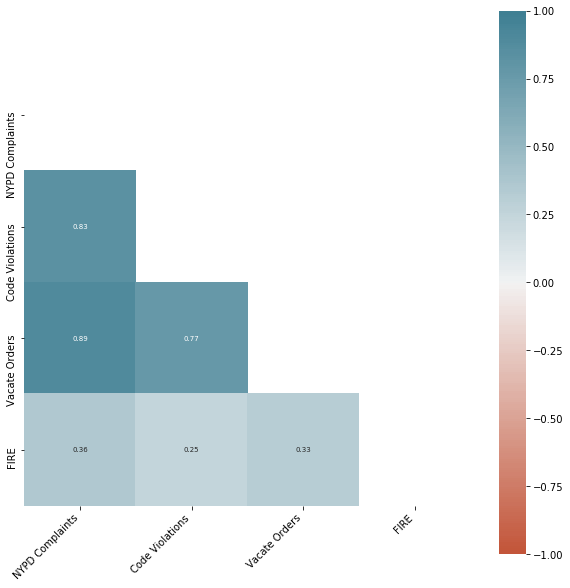

In [59]:
# Correlation heat map with our predictive variables
comb = pd.concat([X, y], axis = 1)
corr = comb.corr()

plt.figure(figsize = (10,10))

dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True


ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True, annot_kws={"size": 7},
    mask=dropSelf
)


ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.savefig('Results - Correlation matrix.pdf', bbox_inches = 'tight', pad_inches = 2.5)


## Apply random forest algorithm

In [65]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=200)
random_forest = random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.9690221614813623

In [66]:
sorted(zip(random_forest.feature_importances_, feature_names), reverse=True)

[(0.36, 'NYPD Complaints'),
 (0.355, 'Vacate Orders'),
 (0.285, 'Code Violations')]

## Cross validation and prediction accuracy

In [67]:
# Cross validation score for Random Forest
Score = cross_val_score(random_forest, X, y, cv=3)
round(np.mean(Score)*100, ndigits=4)

96.9216

In [68]:
# Assign a probability score to each location
df['PREDICTION'] =  random_forest.predict_proba(X)[:,1]
df.PREDICTION.describe()

count    149265.000000
mean          0.969251
std           0.072769
min           0.797045
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: PREDICTION, dtype: float64

In [69]:
# Compare fires found in the 2000 highest risk locations versus randomness
np.random.seed(0)
df['RANDOM'] = np.random.rand(df.shape[0])
df_random = df.nlargest(2000, columns = 'RANDOM')

rf_results_search = df.nlargest(2000, columns = 'PREDICTION')
print('Total predicted fires (2000 interventions): ' + str(rf_results_search.FIRE.sum()))
print('Total random predicted fires (2000 interventions): ' + str(df_random.FIRE.sum()))


Total 2020 predicted fires (2000 interventions): 2000
Total 2020 random predicted fires (2000 interventions): 1934


## Describe & export results

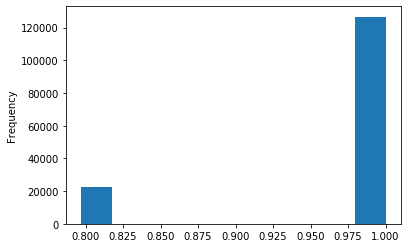

In [70]:
# Visualize how fire risk is distributed among locations
df.PREDICTION.plot.hist()

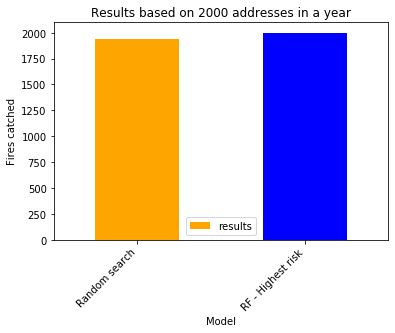

In [71]:
# Plotting the comparison between randomness and sorting by highest risk with our algorithm
random_results = df_random.FIRE.sum()

rf_results = rf_results_search.FIRE.sum()

df_results = pd.DataFrame({'Model' : ['Random search', 'RF - Highest risk'], 'results' : [random_results, rf_results]})
ax = df_results.plot.bar(x = 'Model', y = 'results', color = ['orange', 'b'])

plt.title('Results based on 2000 addresses in a year')
plt.ylabel('Fires catched')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


plt.savefig('Results - Model comparison.pdf', bbox_inches = 'tight', pad_inches = 0.5)

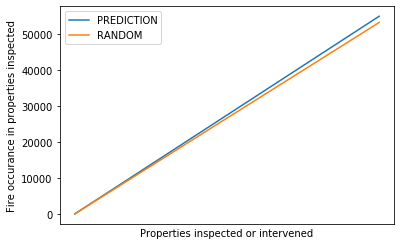

In [72]:
# Comparing our predictive model to randomness
model_comparison = []

for searches in range(0, 55000, 100):
    prediction = df.nlargest(searches, columns = 'PREDICTION').FIRE.sum()
    random = df.nlargest(searches, columns = 'RANDOM').FIRE.sum()
    model_comparison.append([prediction, random])
    
model_comparison_df = pd.DataFrame(model_comparison, columns=['PREDICTION', 'RANDOM'])

model_comparison_df.plot()
plt.xlabel('Properties inspected or intervened')
plt.ylabel('Fire occurance in properties inspected')
plt.xticks([])

plt.savefig('Model comparison - properties intervened.pdf', bbox_inches = 'tight', pad_inches = 2.5)

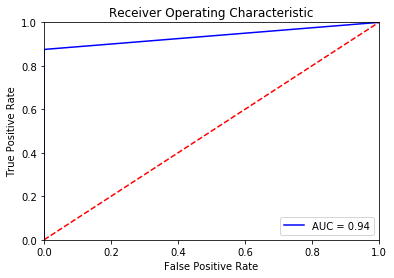

In [73]:
# ROC graph
y_test = df.FIRE
preds = df.PREDICTION

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('AUC ROC curve.pdf', bbox_inches = 'tight', pad_inches = 2.5)

In [74]:
# Feature importance from the RFC 
feature_importances = pd.DataFrame(random_forest.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',                                                                 
                                                                        ascending=False)
feature_importances

,importance
NYPD Complaints,0.360
Vacate Orders,0.355
Code Violations,0.285
